In [17]:
import os
from igor2.packed import load as loadpxp

import matplotlib.pylab as plt
import numpy as np
import statistics

## try with one file

In [3]:
datafile = loadpxp('D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm20Jun2024c0/nm20Jun2024c0_002.pxp')

In [4]:
datafile

([<UnknownRecord-11 1967299754768>,
  <UnknownRecord-20 1967284367568>,
  <UnknownRecord-11 1967286610256>,
  <HistoryRecord 1967286484816>,
  <VariablesRecord 1967292624656>,
  <WaveRecord 1967292650768>,
  <WaveRecord 1967278419984>,
  <WaveRecord 1967285646992>,
  <WaveRecord 1967282509584>,
  <WaveRecord 1967232944080>,
  <WaveRecord 1967285786640>,
  <WaveRecord 1967282569744>,
  <WaveRecord 1967285252752>,
  <WaveRecord 1967278238352>,
  <WaveRecord 1967292648080>,
  <WaveRecord 1967284390288>,
  <WaveRecord 1967282578064>,
  <WaveRecord 1967282581200>,
  <WaveRecord 1967299754448>,
  <WaveRecord 1967292623120>,
  <WaveRecord 1967286484496>,
  <WaveRecord 1967284365136>,
  <WaveRecord 1967284104272>,
  <WaveRecord 1967284361232>,
  <WaveRecord 1967286483856>,
  <WaveRecord 1967285252368>,
  <WaveRecord 1967292646800>,
  <WaveRecord 1967300495248>,
  <WaveRecord 1967300496976>,
  <WaveRecord 1967300550480>,
  <WaveRecord 1967300501776>,
  <WaveRecord 1967300558800>,
  <WaveRecord 

In [7]:
Data = datafile[1]['root']
Data.keys()

dict_keys(['K0', 'K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 'K12', 'K13', 'K14', 'K15', 'K16', 'K17', 'K18', 'K19', 'K20', b'FileFormat', b'FileDateTime', b'SamplesPerWave', b'SampleInterval', b'CT_RecordMode', b'FileFormatStr', b'FileType', b'FileDate', b'FileTime', b'WavePrefix', b'CurrentPrefix', b'xLabel', b'AcqMode', b'FileFinish', b'CT_TimeStamp', b'CT_TimeIntvl', b'yLabel', b'RecordA0', b'RecordA1', b'RecordA2', b'RecordA3', b'RecordA4', b'RecordA5', b'RecordA6', b'RecordA7', b'RecordA8', b'RecordA9', b'RecordA10', b'RecordA11', b'RecordA12', b'RecordA13', b'RecordA14', b'RecordA15', b'RecordA16', b'RecordA17', b'RecordA18', b'RecordA19', b'RecordA20', b'RecordA21', b'RecordA22', b'RecordA23', b'RecordA24', b'RecordA25', b'RecordA26', b'RecordA27', b'RecordA28', b'RecordA29', b'RecordA30', b'RecordA31', b'RecordA32', b'RecordA33', b'RecordA34', b'RecordA35', b'RecordA36', b'RecordA37', b'RecordA38', b'RecordA39', b'RecordA40', b'RecordA41', b'RecordA42',

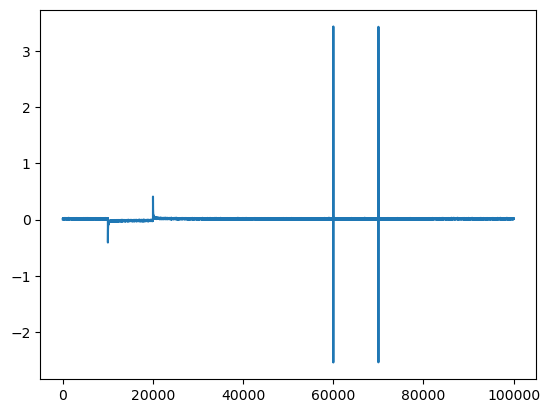

In [16]:
recording = Data[b'RecordA250'].wave['wave']['wData']
plt.plot(recording)

### find baseline

In [20]:
recording_baseline = recording[52000:58000]
avg_baseline = statistics.mean(recording_baseline)
print(avg_baseline)

0.01430582429754456


### find minimum

In [ ]:
recording_roi = recording[61000:65000]
min = np.min(recording_roi)

### find diff

In [22]:
diff = avg_baseline - min
print(diff)

TypeError: unsupported operand type(s) for -: 'float' and 'builtin_function_or_method'

## try for all files

In [6]:
def find_nm_files(root_folder):
    nm_paths = []
    
    # Walk through all directories and files in the root_folder
    for folder, _, files in os.walk(root_folder):
        # Check each file in the current directory
        for file in files:

            # Skip files with specific extensions
            if any(ext in file for ext in ['HDF5', 'txt', 'pdf', 'log', 'xlsx']):
                break
            # Construct the full path of the file
            file_path = os.path.join(folder, file)
            normalized_path = os.path.normpath(file_path)
            forward_slash_path = normalized_path.replace("\\", "/")
            nm_paths.append(forward_slash_path)
            #print('-', file)

    return nm_paths

In [10]:
files = find_nm_files('D:\Internship_Rebola_ICM\RAW_DATA_TO_ANALYSE_WASHOUT')
files

['D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm20Jun2024c0/nm20Jun2024c0_002.pxp',
 'D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm21Jun2024c0/nm21Jun2024c0_000.pxp',
 'D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm28Jun2024c1/nm28Jun2024c1_000.pxp',
 'D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm28Jun2024c0/nm28Jun2024c0_000.pxp']

In [12]:
for file in files:
    try:
        datafile = DataFile(file)
    except Exception as e:
        print(f"Error analysing this file : {e}")

OK data was loaded
Recordings were not loaded: Unable to allocate 229. MiB for an array with shape (300, 100000) and data type float64
Error method get_average_recordings_aligned(self)
OK infos were filled correctly
OK stimulation traces found
data was not loaded
Recordings were not loaded: 'DataFile' object has no attribute 'pxp'
Error method get_average_recordings_aligned(self)
infos were not filled correctly
stimulation parameters not found
OK data was loaded
Recordings were not loaded: Unable to allocate 229. MiB for an array with shape (300, 100000) and data type float64
Error method get_average_recordings_aligned(self)
OK infos were filled correctly
stimulation parameters not found
data was not loaded
Recordings were not loaded: 'DataFile' object has no attribute 'pxp'
Error method get_average_recordings_aligned(self)
infos were not filled correctly
stimulation parameters not found
